# Expressibility of the embedding circuit

Expressibility $\epsilon_{\mathbb{U}}^{(X)}$ is defined by

\begin{aligned}
    \epsilon_{\mathbb{U}}^{(t)}(X) &:= \|A^{(t)}(X)\|_p \,\,\text{or}\,\, \|A^{(t)}(X)\|_\diamond \\
    \mathcal{A}_{\mathbb{U}_x}^{(t)}(X) &:= \int_{\mathcal{U}(d)} d\mu_{\text{Haar}}(V)\,V^{\otimes t}X^{\otimes t}(V^{\otimes t})^\dagger - \int_{\mathbb{U}_x} dU\,U^{\otimes t}X^{\otimes t}(U^{\otimes t})^\dagger.
\end{aligned}


$\|\cdot\|_p$ is Schatten $p$-normm and $\|\cdot\|_\diamond$ is diamond norm.



For $\epsilon_{\mathbb{U}}^{(2)}(X) = \|A^{(t)}(X)\|_2$, the expressibility is redefined by frame potential as follows:

\begin{aligned}
    \epsilon_{\mathbb{U}}^{(2)}(X) &:= \sqrt{\mathcal{F}_{\mathbb{U}}^{(2)}(X) - \mathcal{F}_{Haar}^{(2)}(X) }\\
    \mathcal{F}_{\mathbb{U}}^{(2)}(X) &:= \int_{U\in\mathbb{U}}\int_{V\in\mathbb{U}} dUdV \operatorname{Tr}[XW^\dagger VX^\dagger V^\dagger W],\\
    \mathcal{F}_{\mathbb{U}}^{(2)}(X) &:= \int_{U\in\mathcal{U}}\int_{V\in\mathcal{U}} dUdV \operatorname{Tr}[XW^\dagger VX^\dagger V^\dagger W].
\end{aligned}

When quantifying the expressibility of the embedding circuit, $ X = |0\rangle\langle0| $ is used. Then,
\begin{aligned}
    (\epsilon_{\mathbb{U}}^{(2)}(|0\rangle\langle0|))^2 = \int_{U\in\mathbb{U}}\int_{V\in\mathbb{U}} dUdV |\langle0|W^\dagger V|0\rangle|^4 - \frac{1}{2^{n-1}(2^n + 1)}
\end{aligned}

## Frame potential

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

import warnings
warnings.filterwarnings('ignore')

In [2]:
def analytical_haar_frame_potential(nqubits):
        return 1/(2**(nqubits-1) * (2**nqubits + 1))

class EXPRESSIBILITY_2:
    def __init__(self, nqubits, nlayers, nsamples):
        self.nqubits = nqubits
        self.nlayers = nlayers
        self.nsamples = nsamples

    def HEE(self, circuit, params):
        for i in range(self.nqubits):
            circuit.rx(params[i], i)
            circuit.ry(params[i + self.nqubits], i)
        for i in range(self.nqubits - 1):
            circuit.cx(i, i+1)

    def generate_circuit_state(self, params):
        circuit = QuantumCircuit(self.nqubits)

        for i in range(self.nlayers):
            self.HEE(circuit, params[ 2*self.nqubits*i : 2*self.nqubits*(i+1) ])

        state = qi.Statevector.from_instruction(circuit)
        return state

    def make_random_params(self):
        params = np.random.uniform(0, 2*np.pi, 2*self.nqubits*self.nlayers)
        return params

    def random_inner_product(self):
        params1 = self.make_random_params()
        state1 = self.generate_circuit_state(params1)
        params2 = self.make_random_params()
        state2 = self.generate_circuit_state(params2)

        return np.abs(state1.inner(state2))

    def circuit_frame_potential(self):
        samples = []
        for _ in range(self.nsamples):
            samples.append(self.random_inner_product()**4)
        return np.mean(samples)

    def expressibility(self):
        circuit_frame_potential_ = self.circuit_frame_potential()
        analytical_haar_frame_potential_ = analytical_haar_frame_potential(self.nqubits)

        expressibility_ = (circuit_frame_potential_ - analytical_haar_frame_potential_)**0.5
        return expressibility_

In [3]:
nqubits_list = np.arange(2, 7)
nlayers_list = [1,2,3,4,5,6]
nsamples = 10**3

samples_each_nqubits = []
for nqubits in nqubits_list:
    samples_each_nlayers = []
    for nlayers in nlayers_list:
        exp = EXPRESSIBILITY_2(nqubits, nlayers, nsamples)
        samples_each_nlayers.append(exp.circuit_frame_potential())
    samples_each_nqubits.append(samples_each_nlayers)

In [4]:
analytical_samples_each_nqubits = []
for nqubits in nqubits_list:
    analytical_samples_each_nlayers = []
    for nlayers in nlayers_list:
        analytical_samples_each_nlayers.append(analytical_haar_frame_potential(nqubits))
    analytical_samples_each_nqubits.append(analytical_samples_each_nlayers)

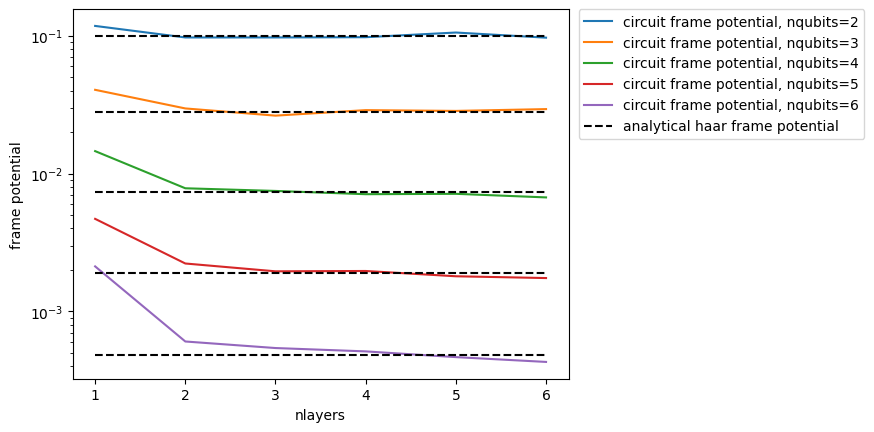

In [5]:
for i in range(len(nqubits_list)):
    plt.semilogy(nlayers_list, samples_each_nqubits[i], label=f'circuit frame potential, nqubits={nqubits_list[i]}')

for i in range(len(nqubits_list)-1):
    plt.semilogy(nlayers_list, analytical_samples_each_nqubits[i], linestyle='dashed', color='black')
plt.semilogy(nlayers_list, analytical_samples_each_nqubits[-1], label=f'analytical haar frame potential', linestyle='dashed', color='black')

plt.xlabel('nlayers')
plt.ylabel('frame potential')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

#### Because the circuit frame potential converges to the analytical haar frame potential so quickly as the number of layers increases, it seems difficult to estimate the expressibility, which is defined by the subtraction of the circuit frame potential and the haar frame potential.

In [8]:
samples_each_nlayers_ = np.array(samples_each_nqubits).T

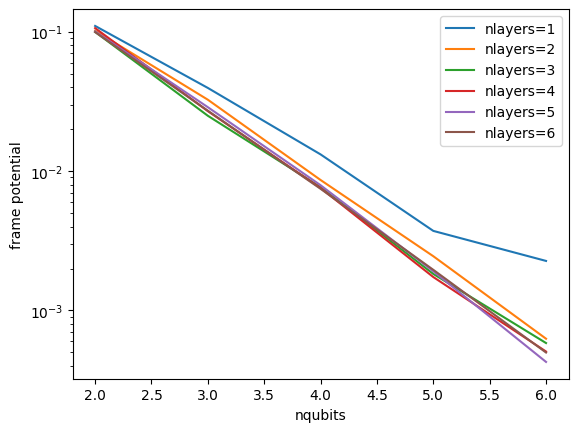

In [9]:
for i in range(len(nlayers_list)):
    plt.semilogy(nqubits_list, samples_each_nlayers_[i], label=f'nlayers={nlayers_list[i]}')
plt.xlabel('nqubits')
plt.ylabel('frame potential')
plt.legend()
plt.show()

## Estimate the expressibility with 1-norm 

### $\epsilon_{\mathbb{U}}^{(2)}(X) = \|A^{(2)}(X)\|_1 = \operatorname{Tr}|\int_{\mathcal{U}(d)} d\mu_{\text{Haar}}(V)\,V^{\otimes 2}X^{\otimes 2}(V^{\otimes 2})^\dagger - \int_{\mathbb{U}_x} dU\,U^{\otimes 2}X^{\otimes 2}(U^{\otimes 2})^\dagger|$

### The first term in the trace is estimated as follows: $ \int_{\mathcal{U}(d)} d\mu_{\text{Haar}}(V)\,V^{\otimes 2}X^{\otimes 2}(V^{\otimes 2})^\dagger = (\mathbb{I}_{d^2} + F)/d(d+1)$, where $F$ is SWAP: $ \sum_{i,j=1}^d |ij\rangle\langle ij|$

ref: http://arxiv.org/abs/1408.3782 Eq. (3.27)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import *

from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

import warnings
warnings.filterwarnings('ignore')

In [9]:
def analytical_haar_frame_potential(nqubits):
        return 1/(2**(nqubits-1) * (2**nqubits + 1))

class EXPRESSIBILITY_1:
    def __init__(self, nqubits, nlayers, nsamples):
        self.nqubits = nqubits
        self.nlayers = nlayers
        self.nsamples = nsamples

    def HEE(self, circuit, params):
        for i in range(self.nqubits):
            circuit.rx(params[i], i)
            circuit.ry(params[i + self.nqubits], i)
        for i in range(self.nqubits-1):
            circuit.cx(i, i+1)

    def generate_circuit_state(self, params):
        circuit = QuantumCircuit(self.nqubits)

        for i in range(self.nlayers):
            self.HEE(circuit, params[ 2*self.nqubits*i : 2*self.nqubits*(i+1) ])

        rho = qi.DensityMatrix.from_instruction(circuit)
        return rho

    def make_random_params(self):
        params = np.random.uniform(0, 2*np.pi, 2*self.nqubits*self.nlayers)
        return params

    def generate_circuit_integrand(self):
        rho = self.generate_circuit_state(self.make_random_params()).to_operator()
        integrand = rho.tensor(rho)
        return integrand

    def generate_haar_integral(self):
        d = 2**self.nqubits
        N = 2**(2*self.nqubits)
        identity = np.eye(N)
        SWAP = np.zeros((N, N))
        for i in range(d):
            for j in range(d):
                SWAP[i*d + j, j*d + i] = 1
        integral = (identity + SWAP)/(d*(d+1))
        return integral

    def expressibility(self):
        rho_integral = 0
        for _ in range(self.nsamples):
            rho_integral += self.generate_circuit_integrand()
        rho_integral /= self.nsamples

        haar_integral = self.generate_haar_integral()

        expressibility_ = norm(haar_integral - rho_integral, 'nuc')# 'nuc' for 1-norm, 'fro' for 2-norm
        return expressibility_

In [13]:
nqubits = 3
nlayers_list = [1,10,50,100]
nsamples = 10**3

samples = []
for nlayers in nlayers_list:
    exp = EXPRESSIBILITY_1(nqubits, nlayers, nsamples)
    samples.append(exp.expressibility())

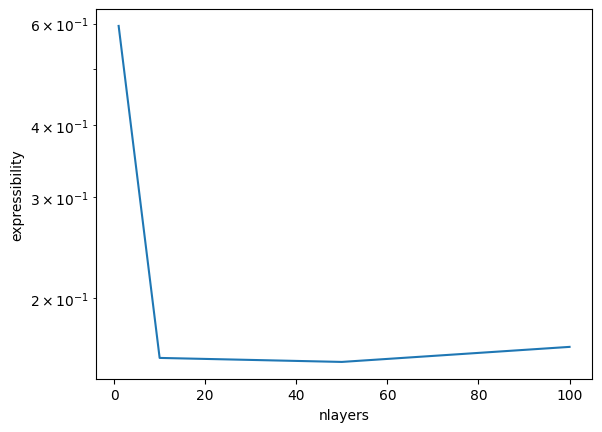

In [15]:
plt.semilogy(nlayers_list, samples)
plt.xlabel('nlayers')
plt.ylabel('expressibility')
plt.show()